In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams.update({'font.size':15})

import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

import tools.generalTools as gt
import tropicalOrographicRegions.mountainUtils as mu

from scipy.stats import linregress
from scipy.ndimage import gaussian_filter
from scipy.integrate import cumtrapz

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.lines

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Data

## Simulations

In [2]:
from tools.wrfHrTools import Simulation,change_coords_pl

In [3]:
import orographicConvectionTheory.orographicConvectionTheory as orog 
xx,hx=orog.topographic_profile('cos',A=500.)

In [4]:
def upstream_mean(ds,reverse=False):
    if reverse:
        return ds.sel(distance_from_mtn=slice(-4000,-2500)).mean('distance_from_mtn')
    else:
        return ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')
    
def prime(ds,reverse=False):
    return ds - upstream_mean(ds,reverse)

def averageB(ds,psfc,ptop=850):
    ds = ds.bfill(dim='pressure')
    p1 = 990;p2=ptop
    part1 = -ds.sel(pressure=slice(p1,p2)).integrate('pressure')
    part2 = ds.sel(pressure=p1)*(psfc-990)
    return ((part1+part2)/(psfc-ptop))
def averageL(ds,p1 = 850,p2 = 500):
    return (-ds.sel(pressure=slice(p1,p2)).integrate('pressure')/(p1-p2))

class SimulationCustom2(Simulation):
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        self.RAINNC_MEAN = xr.open_dataarray(self.path+'wrf.RAINNC.ALLMEAN.nc')
        RAINNC_DAILY = xr.open_zarr(self.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY.mean('south_north').coarsen(Time=24).mean()
        self.RAINNC_DAILY = RAINNC_DAILY
        self.RAINNC_STERR = 2 * RAINNC_DAILY.std('Time').load() / np.sqrt(len(RAINNC_DAILY.Time))
        
        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
        self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')

W10S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W12S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/'          ,1635,3,'1970010100-1971010400',inp=True)   

In [5]:
W10S300.color='c'
W12S300.color='blue'

W10S300.label=r'$U = 10$ m$\,$s$^{-1}$'
W12S300.label=r'$U = 12$ m$\,$s$^{-1}$'

In [6]:
for Sim in W10S300 , W12S300:
    Sim.PSFC_MEAN = xr.open_zarr(Sim.path + "wrf.PSFC_INTERP.1h.%s.zarr"%Sim.suffix2).PSFC[-480:].mean(('Time','south_north')).load()
    Sim.THETAE_MEAN = xr.open_dataarray(Sim.path + "wrf.THETAE.ALLMEAN.nc")
    
    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.U_PL.ALLMEAN.nc')
    Sim.OMEGA_PL_MEAN = -Sim.T_PL_MEAN.pressure*100/(287. * Sim.T_PL_MEAN) * 9.81 * Sim.W_PL_MEAN
    udthetaedx = -(Sim.U_PL_MEAN*Sim.THETAE_MEAN.differentiate('distance_from_mtn')/1000 * 86400)
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*Sim.THETAE_MEAN.differentiate('pressure')/100 * 86400)
    Qthetae = udthetaedx+omegadthetaedp
    Sim.OMEGADTHETAEDP = omegadthetaedp
    
    omegadthetaedp = (Sim.OMEGA_PL_MEAN*upstream_mean(W10S300.THETAE_MEAN).differentiate('pressure')/100 * 86400)
    Sim.OMEGADTHETAE0DP = omegadthetaedp
    
    Sim.QTHETAE = Qthetae

In [139]:
dqdz_wrf = (upstream_mean(W10S300.Q_PL_MEAN).differentiate('pressure')/100 * (- 9.81 * W10S300.Q_PL_MEAN.pressure *100/ (287*upstream_mean(W10S300.T_PL_MEAN))))
dqdz000 = np.interp(pres0[::-1],dqdz_wrf.pressure[::-1],dqdz_wrf[::-1])[::-1]


In [161]:
dqdz_wrf.sel(pressure=slice(900,600)).integrate('pressure')/(-300)

<xarray.DataArray ()>
array(-2.83996788e-06)

In [165]:
dqdz000[10:40].mean()

-2.7433302702316715e-06

In [168]:
np.gradient(0.015 * np.exp(-zz_full0/2500),zz_full0)[10:40].mean()

-2.3795783455703926e-06

In [167]:
np.gradient(0.02 * np.exp(-zz_full0/1500),zz_full0)[10:40].mean()

-3.0413547577575565e-06

(1000.0, 100.0)

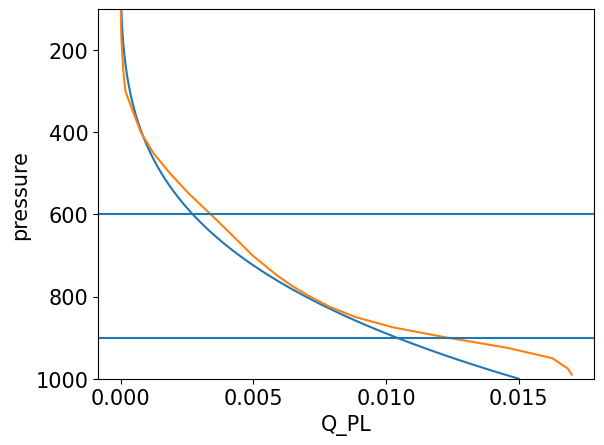

In [169]:
plt.plot(0.015 * np.exp(-zz_full0/2500),pres0)
upstream_mean(W10S300.Q_PL_MEAN).plot(y='pressure')
plt.axhline(900)
plt.axhline(600)
plt.ylim(1000,100)

(1000.0, 100.0)

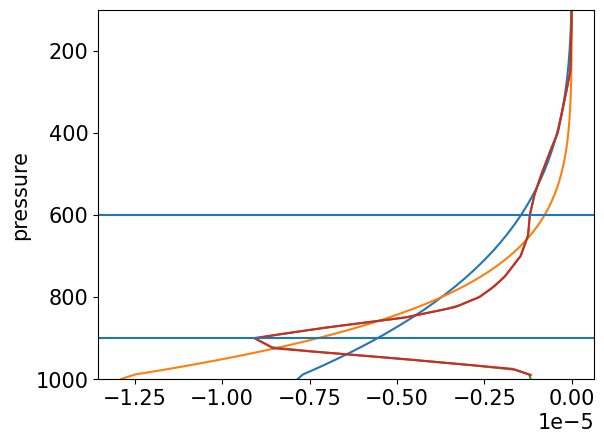

In [158]:
plt.plot(np.gradient(0.02 * np.exp(-zz_full0/2500),zz_full0),pres0)
plt.plot(np.gradient(0.02 * np.exp(-zz_full0/1500),zz_full0),pres0)
plt.plot(dqdz000,pres0)
dqdz_wrf.plot(y='pressure')
plt.axhline(900)
plt.axhline(600)
plt.ylim(1000,100)

(1000.0, 100.0)

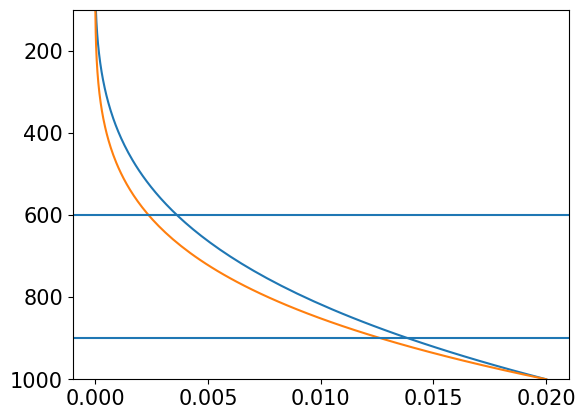

In [157]:
plt.plot(0.02 * np.exp(-zz_full0/2500),pres0)
plt.plot(0.02 * np.exp(-zz_full0/2000),pres0)
plt.axhline(900)
plt.axhline(600)
plt.ylim(1000,100)

# Coupled model

In [7]:
import scipy.linalg as spl
from scipy.io import loadmat

In [8]:
import perlmutterNotebooks.calc_GW_LRF as cgw
import orographicPrecipitation.observationsAndERA5.linearWaveModels as lwm

In [9]:
import orographicConvectionTheory.orographicConvectionTheory as orog

In [170]:
g = 9.81
Lv = 2.5e6
cp=1004.
Rd = 287.
T0=300.
def coupled_gw_mode_damped_noitp(z,ds0dz,dq0dz,k,hhatk,U0,eps,MM,coupling='full',hydrostatic=False,anelastic=False,rhobar=None,eps_therm=None):
    n = len(z)
    dz = z[1]-z[0]
    if eps_therm is None:
        eps_therm=eps
        
    A = cgw.make_A_damped(z,ds0dz*g/T0/U0**2,k,U0,eps,hydrostatic=hydrostatic,anelastic=anelastic,rhobar=rhobar,eps_therm=eps_therm)
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    
    strat_matrix = np.vstack((np.diag(ds0dz),np.diag(dq0dz)*1000))
    
    if coupling=='full':
        rhs_matrix = 1/(1-1j*eps/(k*U0))/(1-1j*eps_therm/(k*U0)) * g/T0/U0**2 * np.linalg.multi_dot((MM[:len(z)]/86400,np.linalg.inv(MM/86400-(1j*k*U0+eps_therm)*np.eye(2*len(z))),strat_matrix))
        A[1:-1] -= rhs_matrix[1:-1]
        ww = np.linalg.solve(A,b)
        Tq = np.linalg.multi_dot((np.linalg.inv(MM/86400-(1j*k*U0+eps_therm)*np.eye(2*len(z))),strat_matrix,ww))
        QcQq = np.dot(MM/86400,Tq)
        return ww,Tq[:len(z)],Tq[len(z):],QcQq[:len(z)],QcQq[len(z):]
    elif coupling=='none':
        ww = np.linalg.solve(A,b)
        Tq = -1/(1j*k*U0+eps_therm)*np.dot(strat_matrix,ww)
        QcQq = np.dot(MM/86400,Tq)
        return ww,Tq[:len(z)],Tq[len(z):],QcQq[:len(z)],QcQq[len(z):]
    else:
        raise ValueError("QN: Not implemented")


def linear_w_coupled(U0=10.,stride=6,start=34,coupling='full',MM=None,eps=1/86400,Sim=W10S300,hydrostatic=False,eps_therm=None):#niter_per_mode=4
    if MM is None:
        print('LRF has not been specified, will be 0')
        MM = np.zeros((400,400))
    xx ,hx = orog.topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    
    zz_full = np.linspace(0,20e3,200)
    p = lwm.z_to_p_standard(zz_full)
    #ds0dz_itp = np.interp(p,Sim.ds0dz.pressure[::-1],Sim.ds0dz[::-1])
    #dq0dz_itp = np.interp(p,Sim.dq0dz.pressure[::-1],Sim.dq0dz[::-1])
    ds0dz_itp = 0.01 **2 * 300/9.81 * zz_full**0
    #dq0dz_itp = dqdz000
    dq0dz_itp = np.gradient(0.015 * np.exp(-zz_full/2500),zz_full)
    #np.gradient(0.02 * np.exp(-zz_full/2500),zz_full)

    kk=orog.k_vector(len(xx),xx[1]-xx[0]); kk[0] = 1e5 # just some dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    w_hat  =np.zeros((len(kk),len(zz_full)))*1j
    T_hat  =np.zeros((len(kk),len(zz_full)))*1j
    q_hat  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hat =np.zeros((len(kk),len(zz_full)))*1j
    Qq_hat =np.zeros((len(kk),len(zz_full)))*1j

    for i,k in enumerate(kk):
        if i%10==0:
            print(i,end=' ')
        ww,Tprime,qprime,Qc,Qq = coupled_gw_mode_damped_noitp(zz_full,ds0dz_itp,dq0dz_itp,k,h_hat[i],U0,eps,MM,coupling=coupling,hydrostatic=hydrostatic,eps_therm=eps_therm)  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        w_hat [i] = ww
        T_hat [i] = Tprime
        q_hat [i] = qprime / 1e3 # convert back to kg/kg
        Qc_hat[i] = Qc 
        Qq_hat[i] = Qq 
        
    ww     = xr.DataArray(np.real(np.fft.ifft(w_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'z':zz_full},dims=['distance_from_mtn','z']).assign_coords({'pressure':('z',lwm.z_to_p_standard(zz_full))})
    Tprime = xr.DataArray(np.real(np.fft.ifft(T_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'z':zz_full},dims=['distance_from_mtn','z']).assign_coords({'pressure':('z',lwm.z_to_p_standard(zz_full))})
    qprime = xr.DataArray(np.real(np.fft.ifft(q_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'z':zz_full},dims=['distance_from_mtn','z']).assign_coords({'pressure':('z',lwm.z_to_p_standard(zz_full))})
    Qc     = xr.DataArray(np.real(np.fft.ifft(Qc_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'z':zz_full},dims=['distance_from_mtn','z']).assign_coords({'pressure':('z',lwm.z_to_p_standard(zz_full))})
    Qq     = xr.DataArray(np.real(np.fft.ifft(Qq_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'z':zz_full},dims=['distance_from_mtn','z']).assign_coords({'pressure':('z',lwm.z_to_p_standard(zz_full))})
    precip = -Qc.integrate('pressure')*100/9.81 / 2.5e3 *86400
    return ww, Tprime, qprime, Qc, Qq, precip
 

In [ ]:
#LT = (zT>1000.) * (zT<4000.)  
#LT = (LT/LT.sum()) / (7.5*3600)
#
#Lq = (zQ>1000.) * (zQ<4000.)  
#Lq = (Lq/Lq.sum()) / (27.5*3600)
#
#LTq = np.concatenate((-LT,Lq / 1000 * 2.5e3))
#
#vert_struct_T = np.sin((pres-100)/900 * np.pi)* (pres >= 100)
#vert_struct_T = vert_struct_T[:-2]
#vert_struct_T = vert_struct_T * 8000 / np.trapz(vert_struct_T[::-1],pres[:-2][::-1]*100) * 9.81
#
#vert_struct_q = np.exp(-zQ/2500.) # here 2500 is moisture scale height
#vert_struct_q = vert_struct_q * 8000 / np.trapz(vert_struct_q[::-1],pres[:14][::-1]*100) * 9.81
#vert_struct_q = vert_struct_q * 1000. / 2.5e3 # convert to g/kg/day
#
#vert_struct_Tq = np.concatenate((vert_struct_T,vert_struct_q))
#
#MM_AN = np.dot(vert_struct_Tq.reshape((-1,1)),LTq.reshape((1,-1)))

In [115]:
zz_full0 = np.linspace(0,20e3,200)
pres0 = lwm.z_to_p_standard(zz_full0)
ztop0=4000.

LT = (zz_full0>1000.) * (zz_full0<ztop0)  
LT = (LT/LT.sum()) / (7.5/24)
Lq = (zz_full0>1000.) * (zz_full0<ztop0)  
Lq = (Lq/Lq.sum()) / (27.5/24)
LTq = np.concatenate((-LT,Lq / 1000 * 2.5e3))

vert_struct_T = np.sin((pres0-100)/900 * np.pi)* (pres0 >= 100)
vert_struct_T = vert_struct_T * 8000 / np.trapz(vert_struct_T[::-1],pres0[::-1]*100) * 9.81

vert_struct_q = np.exp(-zz_full0/2500.) # here 2500 is moisture scale height
vert_struct_q = vert_struct_q * 8000 / np.trapz(vert_struct_q[::-1],pres0[::-1]*100) * 9.81
vert_struct_q = vert_struct_q * 1000. / 2.5e3 # convert to g/kg/day

vert_struct_Tq = np.concatenate((vert_struct_T,-vert_struct_q))

MM_AN = np.dot(vert_struct_Tq.reshape((-1,1)),LTq.reshape((1,-1)))

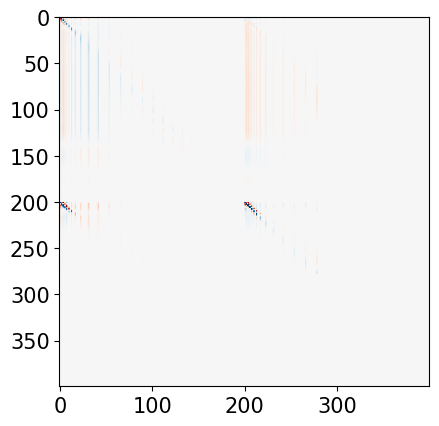

In [110]:
def returnKuang(zz):
    kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")
    
    Mkuang=kuangdata['M']
    pres=kuangdata['pres'][:,0]
    tmean=kuangdata['tmean'][:,0]
    qmean=kuangdata['qmean'][:,0]
    zrce = kuangdata['z'][:,0]
    zT = zrce[:-2]
    zQ = zrce[:14]
    
    #Reverse positive eigenvalue
    lambdas,P = spl.eig(Mkuang)
    lambdas[5]*=-1
    Pm1 = spl.inv(P)
    Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))
    
    itp1_matrix = np.block([[cgw.make_interp_matrix(zz,zrce[:26]),np.zeros((26,len(zz)))],[np.zeros((14,len(zz))),cgw.make_interp_matrix(zz,zrce[:14])]])
    itp2_matrix = cgw.make_interp_matrix(zrce[:26],zz)
    itp3_matrix = np.block([[itp2_matrix,np.zeros((len(zz),14))],[np.zeros((len(zz),26)),cgw.make_interp_matrix(zrce[:14],zz)]])
    
    
    return np.linalg.multi_dot((itp3_matrix,Mkuang2,itp1_matrix))

plt.imshow(returnKuang(zz_full0),cmap = plt.cm.RdBu_r,vmin=-10,vmax=10)

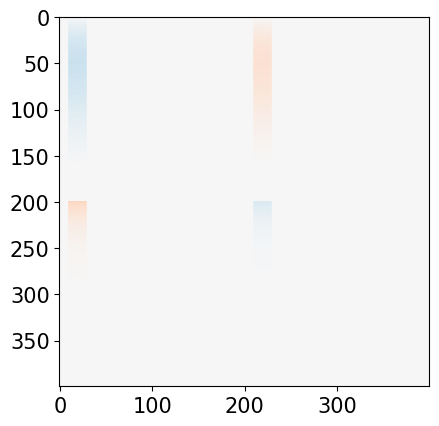

In [111]:
plt.imshow(MM_AN,cmap = plt.cm.RdBu_r,vmin=-1,vmax=1)


## Some tests

In [60]:
def linear_zeta(h,N,U,x,z):
    k=orog.k_vector(len(x),x[1]-x[0])
    zetahat = np.fft.fft(h)[:,None]*np.exp( orog.m_exponent(k[:,None],N,U)  *  z[None,:])
    Tz = 300. + (300.*N**2/9.81 - 9.81/1004.)*z
    lnpz = - cumtrapz(9.81/(287.*Tz),z,initial=0.)
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x/1e3,'z':z,'p':('z',1000.*np.exp(lnpz))},dims={'x':x/1e3,'z':z})
    return zeta

xx,hx = orog.topographic_profile('cos',A=500)
zeta_10 = linear_zeta(hx,0.01,10.,xx,zz_full0)
dq0dz_itp = np.gradient(0.02 * np.exp(-zz_full0/2500),zz_full0)

In [118]:
precip_orig = orog.linear_precip_theory(xx,hx,10,7.5,27.5,50,ztop=ztop0)-50

In [177]:
sol_noc = linear_w_coupled(start=500,stride=2,coupling='none',MM=MM_AN,eps=1/86400,eps_therm=0,hydrostatic=False,Sim=None)
sol_noc_12 = linear_w_coupled(U0=12,start=500,stride=2,coupling='none',MM=MM_AN,eps=1/86400,eps_therm=0,hydrostatic=False,Sim=None)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

In [172]:
sol_noc_noeps = linear_w_coupled(start=500,stride=2,coupling='none',MM=MM_AN,eps=0.01/86400,eps_therm=0,hydrostatic=False,Sim=None)
sol_noc_noeps_12 = linear_w_coupled(U0=12,start=500,stride=2,coupling='none',MM=MM_AN,eps=0.01/86400,eps_therm=0,hydrostatic=False,Sim=None)


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 

In [178]:
(sol_noc_12[-1].max()/sol_noc[-1].max() - 1)*50

<xarray.DataArray ()>
array(24.53711882)

In [181]:
def m_exponent_damped(k,N,U,eps):
    lz2 = N**2/U**2/(1-1j*eps/(k*U))
    m1 = (np.real(lz2) < k**2 ) * 1j*np.sqrt(k**2-lz2 + 0.j) 
    m2 = (np.real(lz2) >= k**2) * np.sign(k)*np.sqrt(lz2-k**2 + 0.j)
    return 1j * (m1 + m2)

def linear_zeta_damped(h,N,U,x,z,eps=1./86400.):
    k=orog.k_vector(len(x),x[1]-x[0]); k[0] = 1e-10 # dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    zetahat = h_hat[:,None]*np.exp( m_exponent_damped(k[:,None],N,U,eps)  *  z[None,:])
    Tz = 300. + (300.*N**2/9.81 - 9.81/1004.)*z
    lnpz = - cumtrapz(9.81/(287.*Tz),z,initial=0.)
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x/1e3,'z':z,'p':('z',1000.*np.exp(lnpz))},dims={'x':x/1e3,'z':z})
    return zeta

In [182]:
xx,hx = orog.topographic_profile('cos',A=500)
zz = np.arange(0.,21e3,100.)
zeta_10 = linear_zeta_damped(hx,0.01,10.,xx,zz)
zeta_12 = linear_zeta_damped(hx,0.01,12.,xx,zz)

In [184]:
ds0dz_0 = 300./9.81 * 0.01**2 * 1004.
dq0dz_0 = 2.5e6 * np.gradient(0.015 * np.exp(-zz/2500),zz).mean()
chi = 8000. * (ds0dz_0/(7.5*3600) - dq0dz_0/(27.5*3600))/ 2.5e6 * 86400


P10 = 8000./ 2.5e6 * 86400 * (-1004. * sol_noc[1].sel(z=slice(1000,4000)).mean('z')/(7.5*3600) + 2.6e6*sol_noc[2].sel(z=slice(1000,4000)).mean('z')/(27.5*3600))
P12 = 8000./ 2.5e6 * 86400 * (-1004. * sol_noc_12[1].sel(z=slice(1000,4000)).mean('z')/(7.5*3600) + 2.6e6*sol_noc_12[2].sel(z=slice(1000,4000)).mean('z')/(27.5*3600))

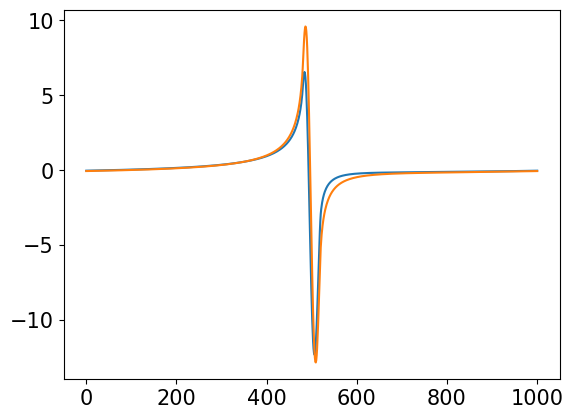

In [187]:
plt.plot(P10)
plt.plot(sol_noc_12[-1])

In [186]:
(sol_noc_12[-1].max()/sol_noc[-1].max() - 1) * 50

<xarray.DataArray ()>
array(24.57483455)

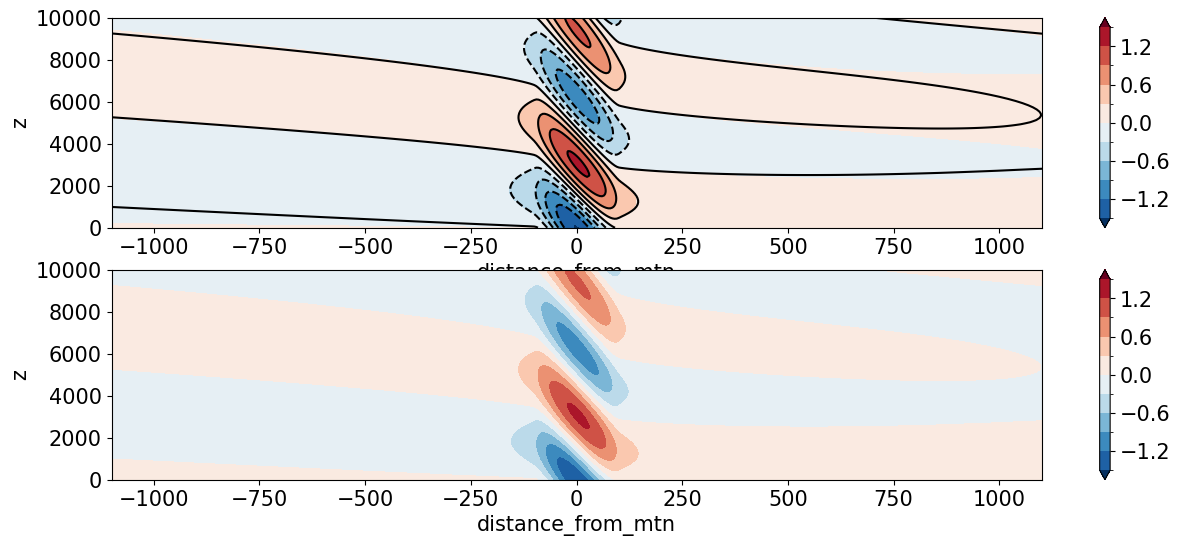

In [183]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(15,6))
(- zeta_10 * 0.01**2 * 300./9.81).plot.contourf(ax=ax,y='z',levels=np.linspace(-1.5,1.5,11),extend='both')
sol_noc[1].plot.contour(ax=ax,y='z',levels=np.linspace(-1.5,1.5,11),colors='k')
sol_noc[1].plot.contourf(ax=ax2,y='z',levels=np.linspace(-1.5,1.5,11),extend='both')
for a in ax,ax2:
    a.set_xlim(-1100,1100)
    a.set_ylim(0,10e3)

In [174]:
(sol_noc_noeps_12[-1].max()/sol_noc_noeps[-1].max() - 1)*50

<xarray.DataArray ()>
array(33.15141559)

In [120]:
sol_noc[1]

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 35.7 s, sys: 9.18 s, total: 44.9 s
Wall time: 22.4 s


In [113]:
%time sol_c2 = linear_w_coupled(start=500,stride=2,coupling='full',MM=returnKuang(zz_full0)/2,eps=0.01/86400,hydrostatic=False,Sim=None)


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 32.1 s, sys: 7.58 s, total: 39.7 s
Wall time: 19.8 s


In [ ]:
#Tq_0 = np.vstack((sol_noc[1].data.T,sol_noc[2].data.T*1e3))
#QcQq_0 = np.dot(MM_AN,Tq_0)
#precip = np.trapz(QcQq_0[:200][::-1],pres0[::-1]*100/9.81,axis=0)/2.5e3 

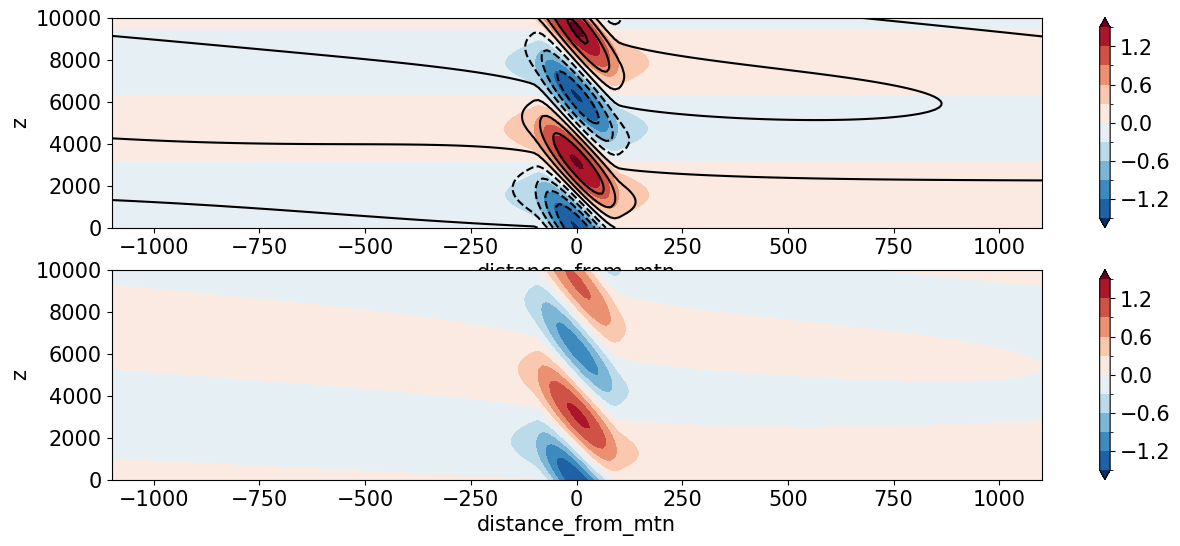

In [176]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(15,6))
(- zeta_10 * 0.01**2 * 300./9.81).plot.contourf(ax=ax,y='z',levels=np.linspace(-1.5,1.5,11),extend='both')
sol_c[1].plot.contour(ax=ax,y='z',levels=np.linspace(-1.5,1.5,11),colors='k')
sol_noc[1].plot.contourf(ax=ax2,y='z',levels=np.linspace(-1.5,1.5,11),extend='both')
for a in ax,ax2:
    a.set_xlim(-1100,1100)
    a.set_ylim(0,10e3)

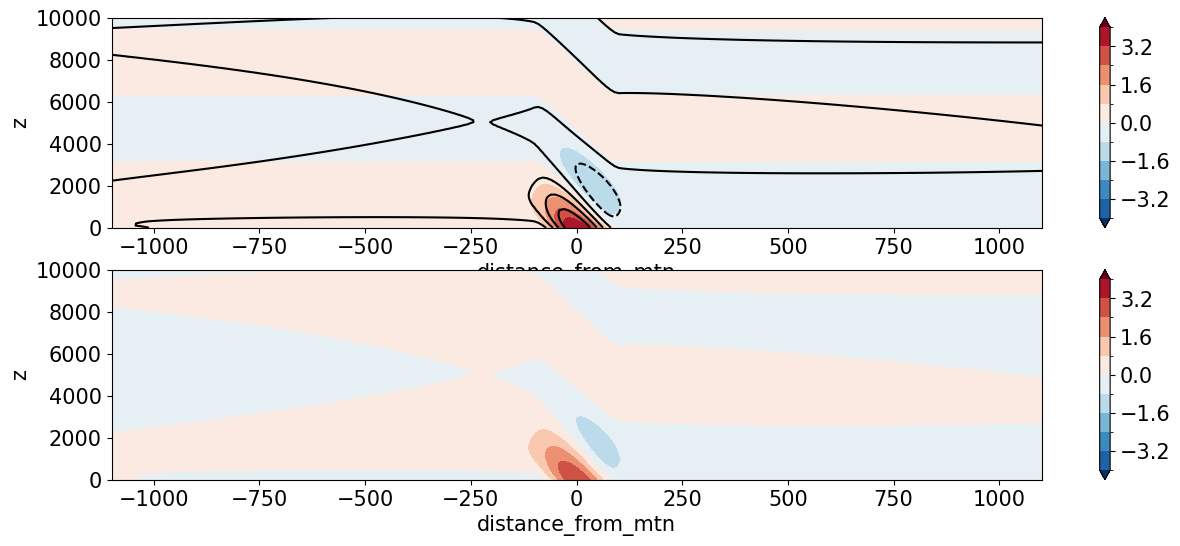

In [76]:
_,(ax,ax2)=plt.subplots(2,1,figsize=(15,6))
levs = np.linspace(-4,4,11)
(- zeta_10 * dq0dz_itp * 1e3).plot.contourf(ax=ax,y='z',levels=levs,extend='both')
(sol_c[2]*1e3).plot.contour(ax=ax,y='z',levels=levs,colors='k')
(sol_c[2]*1e3).plot.contourf(ax=ax2,y='z',levels=levs,extend='both')
for a in ax,ax2:
    a.set_xlim(-1100,1100)
    a.set_ylim(0,10e3)

(-1100.0, 1100.0)

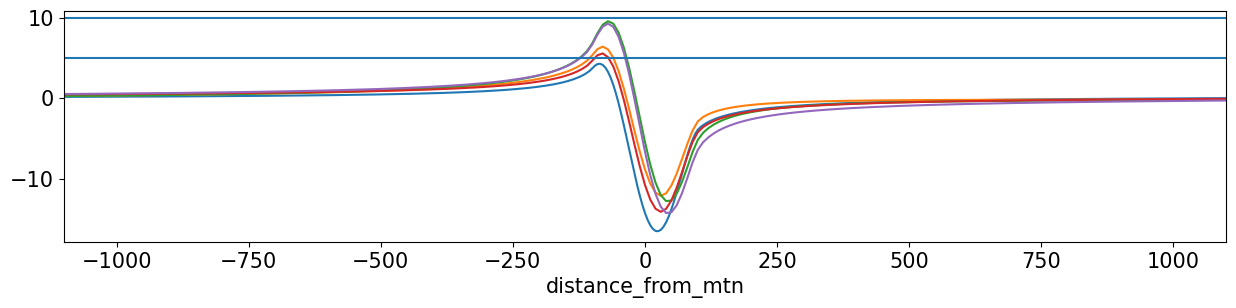

In [175]:
_,axs=plt.subplots(1,1,figsize=(15,3))
plt.plot(zeta_10.x,precip_orig)
sol_noc[-1].plot()
sol_noc_12[-1].plot()
sol_noc_noeps[-1].plot()
sol_noc_noeps_12[-1].plot()

#sol_c[-1].plot()
#sol_c2[-1].plot()
#plt.plot(sol_noc[1].distance_from_mtn,precip)
#plt.plot(sol_c1[1].distance_from_mtn,precip_alamano)
#plt.plot(zeta_10.x,precip_alamano2)
#
#
#plt.plot(sol_c[1].distance_from_mtn,precipc,color='lime')
#

plt.axhline(5)
plt.axhline(10)
plt.xlim(-1100,1100)

(-1100.0, 1100.0)

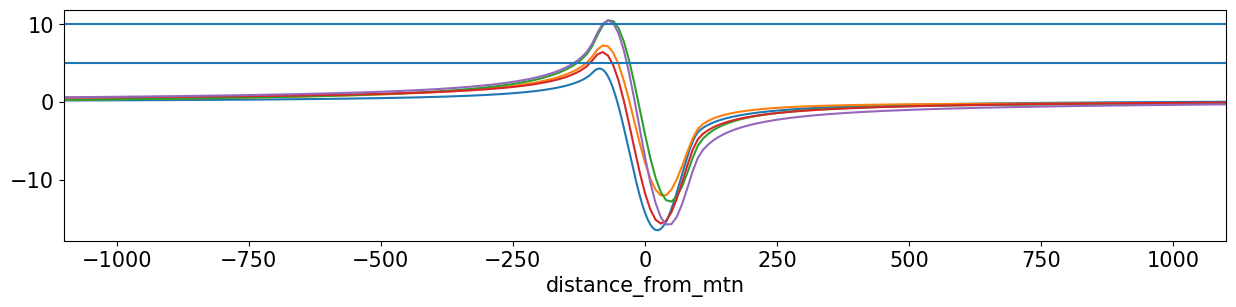

In [147]:
_,axs=plt.subplots(1,1,figsize=(15,3))
plt.plot(zeta_10.x,precip_orig)
sol_noc[-1].plot()
sol_noc_12[-1].plot()

#sol_c[-1].plot()
#sol_c2[-1].plot()
#plt.plot(sol_noc[1].distance_from_mtn,precip)
#plt.plot(sol_c1[1].distance_from_mtn,precip_alamano)
#plt.plot(zeta_10.x,precip_alamano2)
#
#
#plt.plot(sol_c[1].distance_from_mtn,precipc,color='lime')
#

plt.axhline(5)
plt.axhline(10)
plt.xlim(-1100,1100)

In [103]:
zz_full0 = np.linspace(0,20e3,200)
itp10_matrix = np.block([[cgw.make_interp_matrix(zz_full0,zrce[:26]),np.zeros((26,len(zz_full0)))],[np.zeros((14,len(zz_full0))),cgw.make_interp_matrix(zz_full0,zrce[:14])]])   

In [66]:
precip_alamano = ( - sol_c1[1].sel(z=slice(1000,4000)).mean('z') / (7.5/24) + 2.5e3 * sol_c1[2].sel(z=slice(1000,4000)).mean('z') / (27.5/24)) * 8000/2.5e3

In [70]:
Tprime_lin = - zeta_10 * 0.01**2 * 300./9.81
qprime_lin = zeta_10 * 8e-3

precip_alamano2 = ( - Tprime_lin.sel(z=slice(1000,4000)).mean('z') / (7.5/24) + qprime_lin.sel(z=slice(1000,4000)).mean('z') / (27.5/24)) * 8000/2.5e3

In [121]:
zz_full00 = np.linspace(0,20e3,200)
zz_full0 = np.linspace(0,20e3,20)
itp10_matrix = np.block([[cgw.make_interp_matrix(zz_full00,zz_full0),np.zeros((len(zz_full0),len(zz_full00)))],[np.zeros((len(zz_full0),len(zz_full00))),cgw.make_interp_matrix(zz_full00,zz_full0)]])   

In [122]:
LT = (zz_full0>1000.) * (zz_full0<4000.)  
LT = (LT/LT.sum()) / (7.5*3600)
Lq = (zz_full0>1000.) * (zz_full0<4000.)  
Lq = (Lq/Lq.sum()) / (27.5*3600)
LTq = np.concatenate((-LT,Lq / 1000 * 2.5e3))

pres0 = lwm.z_to_p_standard(zz_full0)
vert_struct_T = np.sin((pres0-100)/900 * np.pi)* (pres0 >= 100)
vert_struct_T = vert_struct_T * 8000 / np.trapz(vert_struct_T[::-1],pres0[::-1]*100) * 9.81

vert_struct_q = np.exp(-zz_full0/2500.) # here 2500 is moisture scale height
vert_struct_q = vert_struct_q * 8000 / np.trapz(vert_struct_q[::-1],pres0[::-1]*100) * 9.81
vert_struct_q = vert_struct_q * 1000. / 2.5e3 # convert to g/kg/day

vert_struct_Tq = np.concatenate((vert_struct_T,vert_struct_q))

MM_AN2 = np.dot(vert_struct_Tq.reshape((-1,1)),LTq.reshape((1,-1)))

In [124]:
QcQq_02 = np.linalg.multi_dot((MM_AN2,itp10_matrix,Tq_0))
precip2 = np.trapz(QcQq_02[:len(zz_full0)][::-1],pres0[::-1]*100/9.81,axis=0)/2.5e3*86400 

In [79]:
QcQq_02 = np.dot(MM_AN2,Tq_0)
precip2 = np.trapz(QcQq_02[:200][::-1],pres0[::-1]*100/9.81,axis=0)/2.5e3*86400 

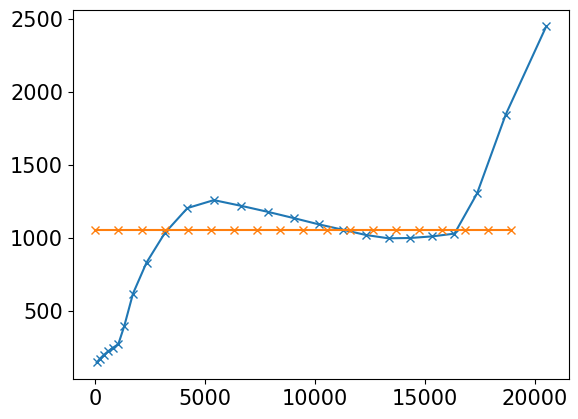

In [120]:
plt.plot(zrce[:25],np.diff(zrce[:26]             ),'-x')
plt.plot(np.linspace(0,20e3,20)[:19],np.diff(np.linspace(0,20e3,20)),'-x')



## Older tests

In [138]:
#Qc = np.dot(MM_AN,np.concatenate((np.zeros(20),np.ones(20))))[:26]
#Qq = np.dot(MM_AN,np.concatenate((np.zeros(20),np.ones(20))))[-14:]
#np.trapz(Qq[::-1],pres[:14][::-1]*100/9.81)/1e3*86400 
#np.trapz(Qc[::-1],pres[:26][::-1]*100/9.81)/2.5e3*86400 

In [62]:
%time w_c1,Tprime_c1,qprime_c1,_,_,precip_c1 = linear_w_coupled(start=500,stride=2,coupling='full',MM=Mkuang2/2,eps=2/86400,hydrostatic=True,Sim=None)




0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 30.3 s, sys: 7.11 s, total: 37.4 s
Wall time: 18.7 s


In [93]:
%time w_c2,Tprime_c2,qprime_c2,_,_,precip_c2 = linear_w_coupled(start=500,stride=2,coupling='full',MM=MM_AN,eps=2/86400,hydrostatic=True,Sim=None)




0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 30.5 s, sys: 7 s, total: 37.5 s
Wall time: 18.8 s


In [150]:
%time w_c2,Tprime_c2,qprime_c2,_,_,precip_c2 = linear_w_coupled(start=500,stride=2,coupling='none',MM=MM_AN,eps=0.1/86400,hydrostatic=True,Sim=None)




0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 1.35 s, sys: 816 ms, total: 2.16 s
Wall time: 1.14 s


In [86]:
%time w_c,Tprime_c,qprime_c,_,_,precip_c = linear_w_coupled(start=500,stride=2,coupling='full',MM=MM_AN,eps=2/86400,hydrostatic=True,Sim=None)




0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 30.6 s, sys: 6.86 s, total: 37.4 s
Wall time: 18.8 s


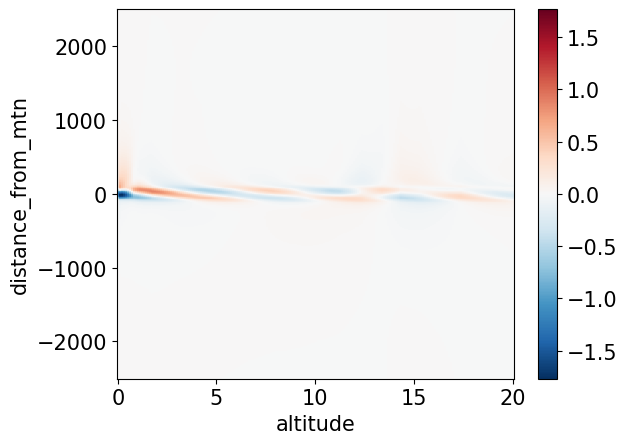

In [18]:
Tprime_c.plot()

(-1100.0, 1100.0)

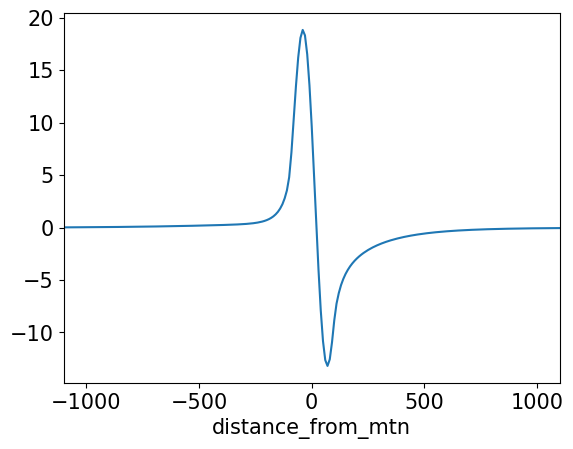

In [63]:
precip_c1.plot()
plt.xlim(-1100,1100)

(-1100.0, 1100.0)

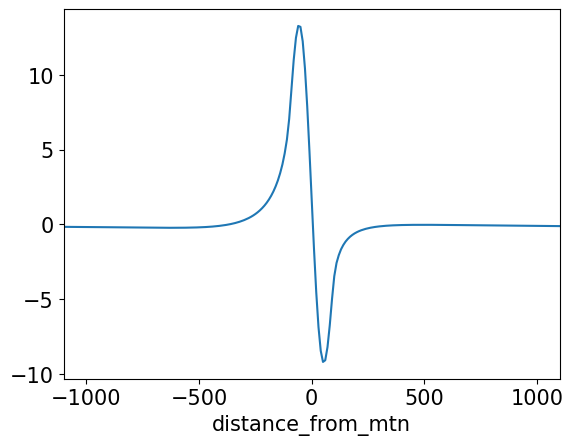

In [87]:
precip_c.plot()
plt.xlim(-1100,1100)

(-1100.0, 1100.0)

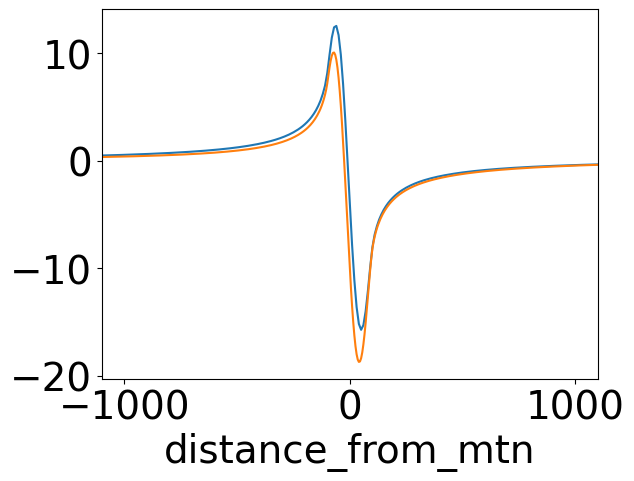

In [151]:
(precip_c2*86400).plot()
Pp_10_2 = orog.linear_precip_theory(xx,hx,10,N=0.01,ztop=3000,P0=50.,tauT=7.5,tauq=27.5) - 50.

plt.plot(xx/1e3,Pp_10_2)
plt.xlim(-1100,1100)

(-1100.0, 1100.0)

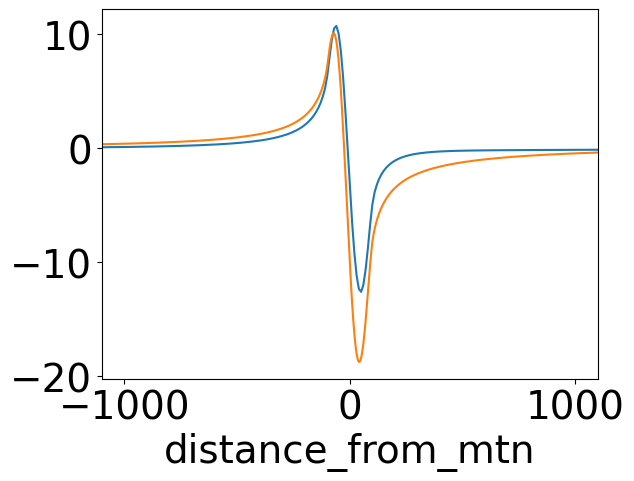

In [118]:
(precip_c2*86400).plot()
Pp_10_2 = orog.linear_precip_theory(xx,hx,10,N=0.01,ztop=3000,P0=50.,tauT=7.5,tauq=27.5) - 50.

plt.plot(xx/1e3,Pp_10_2)
plt.xlim(-1100,1100)

In [8]:
import orographicPrecipitation.observationsAndERA5.linearWaveModels as lwm

In [10]:
xx,hx = orog.topographic_profile('cos',A=500)
zz = np.arange(0.,21e3,100.)

In [11]:
w_adiabatic = lwm.linear_w_1layer(xx,hx,zz,10.,0.01)

(0.0, 10.0)

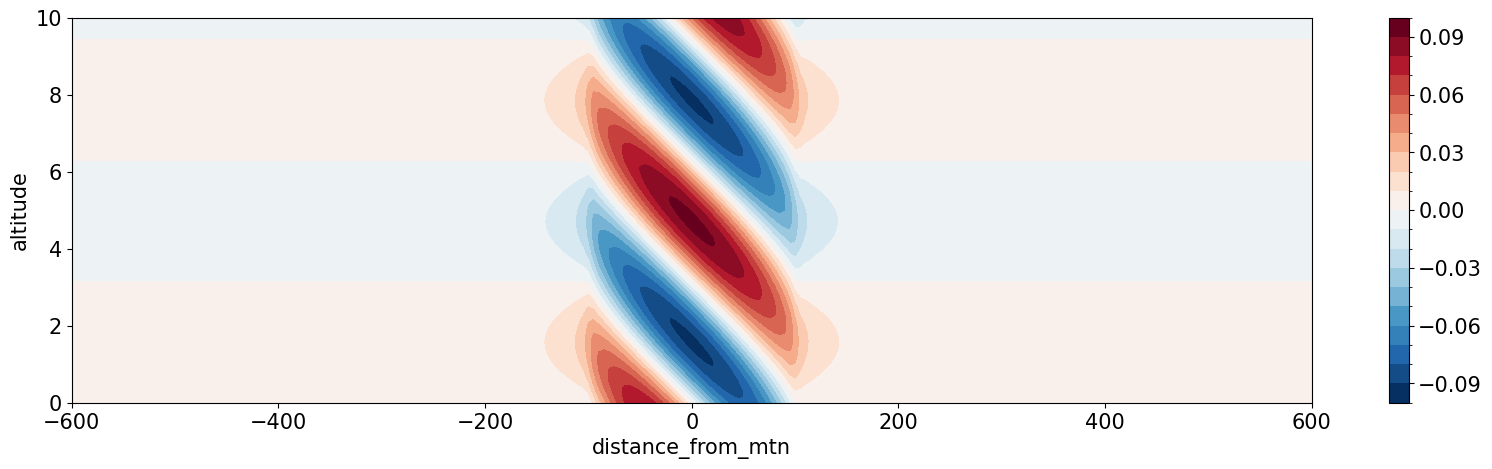

In [19]:
plt.figure(figsize=(20,5))
w_adiabatic.plot.contourf(y='z',levels=np.linspace(-0.1,0.1,21))
plt.xlim(-600,600)
plt.ylim(0,10)

# Theory + Simulation

In [26]:
def linear_zeta(h,N,U,x,z):
    k=orog.k_vector(len(x),x[1]-x[0])
    zetahat = np.fft.fft(h)[:,None]*np.exp( orog.m_exponent(k[:,None],N,U)  *  z[None,:])
    Tz = 300. + (300.*N**2/9.81 - 9.81/1004.)*z
    lnpz = - cumtrapz(9.81/(287.*Tz),z,initial=0.)
    zeta=xr.DataArray(np.real(np.fft.ifft(zetahat,axis=0)),coords={'x':x/1e3,'z':z,'p':('z',1000.*np.exp(lnpz))},dims={'x':x/1e3,'z':z})
    return zeta

In [28]:
xx,hx = orog.topographic_profile('cos',A=500)
zz = np.arange(0.,21e3,100.)
zeta_10 = linear_zeta(hx,0.0085,10.,xx,zz)
zeta_11 = linear_zeta(hx,0.0085,12.,xx,zz)

In [147]:
Pp_10 = orog.linear_precip_theory(xx,hx,10,N=0.0085,ztop=4000,P0=50.,tauT=7.5,tauq=27.5) - 50.
Pp_12 = orog.linear_precip_theory(xx,hx,12,N=0.0085,ztop=4000,P0=50.,tauT=7.5,tauq=27.5) - 50.
Pd_10 = orog.linear_precip_theory(xx,hx,10,N=0.0085,ztop=4000,P0=50.,tauT=7.5,tauq=27.5,switch=1e-4) - 50.
Pd_12 = orog.linear_precip_theory(xx,hx,12,N=0.0085,ztop=4000,P0=50.,tauT=7.5,tauq=27.5,switch=1e-4) - 50.

In [148]:
(Pp_12.max()/Pp_10.max() - 1 )* 50

25.612693687871293

In [149]:
Pp_10.max()

6.68123343499316

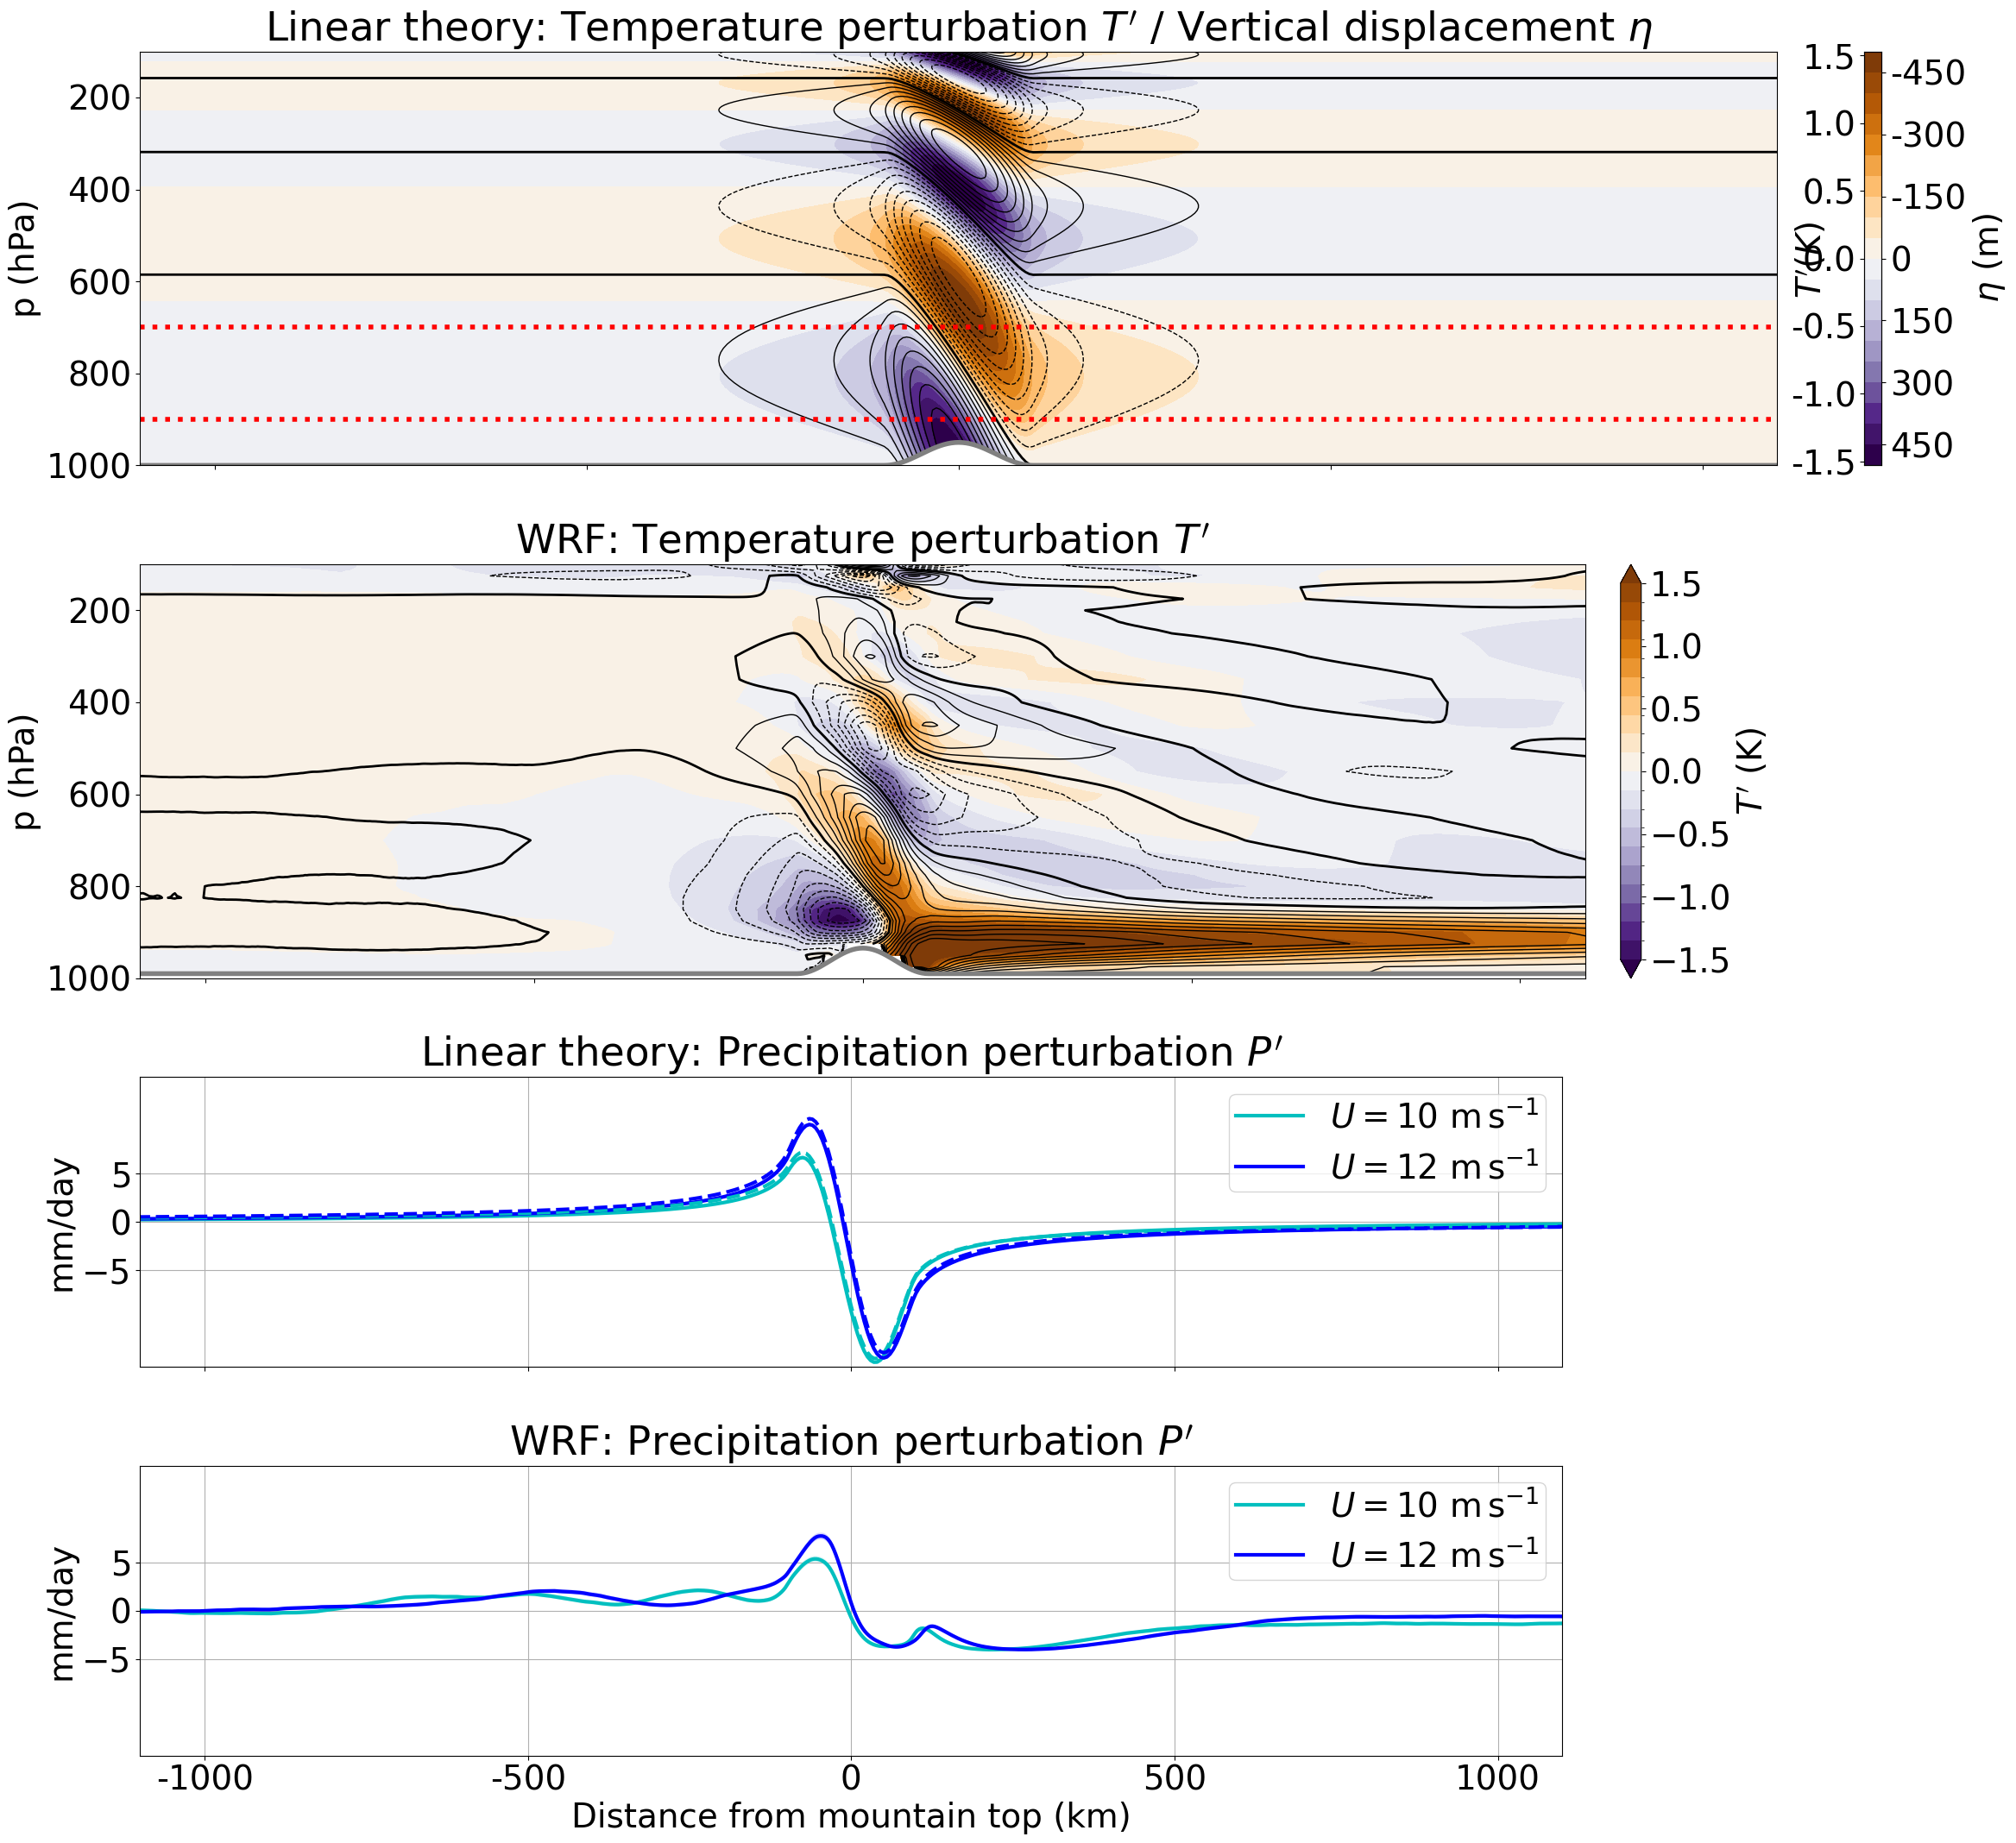

In [115]:
matplotlib.rcParams.update({'font.size': 28})
fig,(ax,axw,ax2,axw2)=plt.subplots(4,1,figsize=(24,22),height_ratios=(1,1,0.7,0.7))


#### FIRST PLOT - eta in linear theory####
levs = np.linspace(-500,500,21)
cbticks = np.arange(-450,451,150) # eta valeus
left_ticks = np.arange(-1.5,1.6,0.5)  # T' values
n=len(levs)

im = (-zeta_10).swap_dims(z='p').plot.contourf(ax=ax, y='p',levels=levs,cmap = plt.cm.PuOr_r,add_colorbar=False)
zeta_11.swap_dims(z='p').plot.contour (ax=ax, y='p',levels=levs,colors=['k']*n,linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# Make the colorbar
ds0dz = (300.*0.01**2/9.81)
colorbar = plt.colorbar(im,label='',pad=0.05,fraction=0.01)
# Add left ticks
colorbar.ax.minorticks_off()
colorbar.ax.set_yticks(left_ticks/ds0dz)
colorbar.ax.set_yticklabels(left_ticks)
colorbar.ax.text(-4,0.42,r"$T'(K)$",transform=colorbar.ax.transAxes,rotation='vertical')
# Add right ticks
secondary_axis = colorbar.ax.twinx()
secondary_axis.set_yticks(cbticks)
secondary_axis.set_yticklabels(cbticks)
secondary_axis.set_ylim(levs[-1],levs[0])
# Set the label for the secondary axis
secondary_axis.set_ylabel(r"$\eta$ (m)")

# fill white space
xplot=zeta_10.x
ax.fill_between(xplot,1000*xplot**0,1000*xplot**0 - hx*0.1,color='w',zorder=2)
ax.plot(xplot,1000-hx/10,color='gray',linewidth=4)

ax.axhline(900.,color='r',linestyle=':',linewidth=4)
ax.axhline(700.,color='r',linestyle=':',linewidth=4)





#### SECOND PLOT - T' in WRF####

levs = np.linspace(-1.5,1.5,21)
n=len(levs)

prime(W10S300.T_PL_MEAN).plot.contourf(ax=axw,y='pressure',yincrease=False,levels=levs,cmap=plt.cm.PuOr_r,extend='both',cbar_kwargs={'label':r"$T'$ (K)",'ticks':left_ticks,"pad":0.02})
prime(W12S300.T_PL_MEAN).plot.contour (ax=axw,y='pressure',yincrease=False,levels=levs,colors='k',linestyles=['--']*(n//2)+['-']*(n//2+1),linewidths=[1]*(n//2) + [2.] + [1]*(n//2))

# fill white space
axw.fill_between(xplot,990*xplot**0,990 - hx/9,color='w',zorder=2)
axw.plot(xplot,990 - hx/9,color='gray',linewidth=4)

#### THIRD PLOT - precip in linear theory ####

ax2.plot(xplot,Pp_10,color='c',linewidth=3,label=r"$U=$10 m$\,$s$^{-1}$")
ax2.plot(xplot,Pp_12,color='b',linewidth=3,label=r"$U=$12 m$\,$s$^{-1}$")
ax2.plot(xplot,Pd_10,color='c',linewidth=3,linestyle='--')
ax2.plot(xplot,Pd_12,color='b',linewidth=3,linestyle='--')

#### FOURTH PLOT - precip in WRF ####
for Sim in (W10S300,W12S300):
    prime(Sim.RAINNC_MEAN).plot(ax=axw2,color=Sim.color,label=Sim.label,linewidth=3)
    axw2.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,prime(Sim.RAINNC_MEAN)-Sim.RAINNC_STERR,prime(Sim.RAINNC_MEAN)+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)

#### COMMON settings ####
for a in ax2,axw2:
    divider2 = make_axes_locatable(a)
    cax2 = divider2.append_axes("right", size=2.7, pad=1.,axes_class=plt.Axes)
    cax2.remove()
    a.grid()
    
    a.set_ylim(-15,15)
    a.set_ylabel("mm/day")
    yticks=np.arange(-5,6,5)
    a.set_yticks(yticks)
    a.legend(loc=1,borderpad=0.2,fontsize=28)
for a in ax,axw:
    a.set_ylim(1000.,100)
    a.set_ylabel('p (hPa)')
    
ticks = np.arange(-1000,1100,500)
for a in ax,axw,ax2,axw2:
    a.set_xlim(-1100,1100)
    a.set_xticks(ticks)
    a.set_xticklabels('')
    a.set_xlabel('')
axw2.set_xticklabels(ticks)
axw2.set_xlabel('Distance from mountain top (km)')



ax.set_title(r"Linear theory: Temperature perturbation $T'$ / Vertical displacement $\eta$")
axw.set_title(r"WRF: Temperature perturbation $T'$")
ax2.set_title(r"Linear theory: Precipitation perturbation $P'$")
axw2.set_title(r"WRF: Precipitation perturbation $P'$")
fig.tight_layout()